# **Ejercicio de clasificación con Keras**


## Integrantes del equipo N° #16:

A00572928 - André Martins Cordebello

A01334976 - Israel Campos Báez

A01166758 - Juan Manuel Carballo Montaño

A01795149 - Kevin Balderas Sánchez

A01793650 - Jessica Paola Pulido Vásquez


## Docentes:

Dr. David Antonio Torres

Dr. Luis Anselmo Fortoul Díaz



**Maestría en Inteligencia Artificial Aplicada**

**MR4010 - Navegación Autónoma**


Fecha: 3 de Junio de 2024

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Se cargan las bibliotecas necesarias

In [38]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=c41a8078e4753420506828d2fd072871651e0aacad9506fda4ec7644a4c36e6b
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [15]:
import cv2
import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from skimage.feature import hog
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten , Input

# Se importan los dos datasets
### https://github.com/cristianrohr/ECI-DATCOM-UGR_Deteccion_peatones/tree/master/data/

In [2]:
pedestrian = glob.glob("./png/data/train/pedestrians/*.png")
background = glob.glob("./png/data/train/background/*.png")

In [3]:
len(pedestrian)

1911

In [4]:
len(background)

2387

# Se muestra una imagen con un peaton

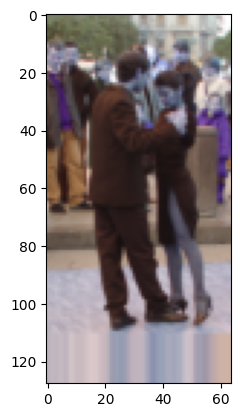

In [5]:
img_color = cv2.imread(pedestrian[10])
plt.imshow(img_color)

In [6]:
def load_and_preprocess_images(image_paths, label, target_size):
    images = []
    labels = []
    for img_path in image_paths:
        img = Image.open(img_path).resize(target_size)  # Redimensionar a (128,64)
        img = img.convert('RGB')  # Asegurarse de que la imagen tenga 3 canales
        img_array = np.array(img) / 255.0  # Normalizar valores entre 0 y 1
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

In [7]:
# Cargar y preprocesar las imágenes (peatones 1, blackground 0)
pedestrian_data, pedestrian_labels = load_and_preprocess_images(pedestrian, 1, (128, 64))
background_data, background_labels = load_and_preprocess_images(background, 0, (128, 64))

In [8]:
# Concatenar los datos y etiquetas
X = np.concatenate((pedestrian_data, background_data), axis=0)
y = np.concatenate((pedestrian_labels, background_labels), axis=0)

In [9]:
# Dividir en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Verificar las formas de los datos
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3438, 64, 128, 3)
Shape of y_train: (3438,)
Shape of X_test: (860, 64, 128, 3)
Shape of y_test: (860,)


# Se verifica el número de muestras por dígito

Text(0, 0.5, 'Número de Muestras')

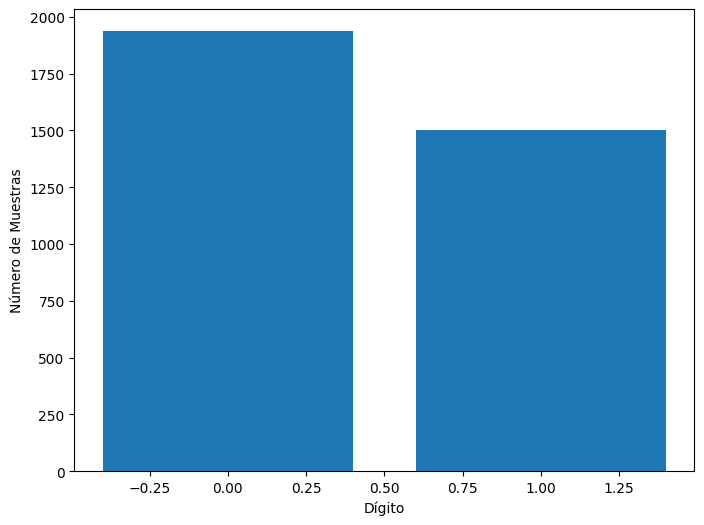

In [11]:
n_muestras = []
n_digitos = 2

for n in range(n_digitos):
    x_sel = X_train[y_train == n]
    n_muestras.append(len(x_sel))
plt.figure(figsize=(8,6))
plt.bar(range(0,n_digitos), n_muestras)
plt.xlabel("Dígito")
plt.ylabel("Número de Muestras")

# Se define la red neuronal y las capas

## Capas Convolucionales y de Pooling:
Las capas convolucionales extraen características espaciales y patrones importantes de las imágenes.
Las capas de pooling (máximo o promedio) reducen la dimensionalidad y ayudan a hacer la red más eficiente y menos propensa al sobreajuste.

## Capas Ocultas Densas:
Después de las capas convolucionales, se usan capas densas (fully connected) para tomar las características extraídas y realizar la clasificación.

## Capa de Salida:
La capa de salida debe tener una sola neurona con una activación sigmoide para producir una salida binaria (0 o 1) indicando si hay un peatón en la imagen o no.

In [27]:
# Diseño de la red neuronal convolucional
model = Sequential()

In [28]:
#input layer
model.add(Input(shape=(128,64,3))) #dimensiones de la imagen una vez procesada

# Capas convolucionales y de pooling
#La función de activación 'relu' se usa para introducir no linealidad.
# padding='same' agrega ceros alrededor de las entradas de tal manera que la salida tenga la misma dimensión espacial que la entrada.

#Primera capa convolucional con 32 filtros de tamaño 3x3.
model.add(Conv2D(32, (3, 3), activation='relu', padding='same' ))
#Reducción de dimensionalidad con un pool de tamaño 2x2.
model.add(MaxPooling2D((2, 2), padding='same'))

#Segunda capa convolucional con 64 filtros de tamaño 3x3.
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Tercera capa convolucional con 128 filtros de tamaño 3x3.
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

In [29]:
# Aplanar la salida de las capas convolucionales para las capas densas
model.add(Flatten())

In [30]:
# Capas densas

# Capas densas con 128 y 64 neuronas respectivamente, usando 'relu' como función de activación.
# Dropout del 20% para prevenir el sobreajuste durante el entrenamiento.

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.20))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.20))

In [31]:
# Capa de salida con una neurona y activación sigmoide

#Una sola neurona con activación sigmoide para salida binaria.

model.add(Dense(1, activation='sigmoid'))

In [32]:
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Resumen del modelo
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 64, 32)         │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,198,849 (8.39 MB)

 Trainable params: 2,198,849 (8.39 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Entrenar el modelo
hist = model.fit(
    X_train, y_train,
    validation_split=0.10,
    verbose=2,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=32,
    shuffle = 1
)

Epoch 1/20
108/108 - 12s - 110ms/step - accuracy: 0.7865 - loss: 0.4264 - val_accuracy: 0.8814 - val_loss: 0.2991
Epoch 2/20
108/108 - 12s - 110ms/step - accuracy: 0.9273 - loss: 0.1903 - val_accuracy: 0.9407 - val_loss: 0.1603
Epoch 3/20
108/108 - 11s - 100ms/step - accuracy: 0.9532 - loss: 0.1287 - val_accuracy: 0.9500 - val_loss: 0.1221
Epoch 4/20
108/108 - 11s - 101ms/step - accuracy: 0.9706 - loss: 0.0803 - val_accuracy: 0.9686 - val_loss: 0.0848
Epoch 5/20
108/108 - 11s - 101ms/step - accuracy: 0.9706 - loss: 0.0731 - val_accuracy: 0.9651 - val_loss: 0.0996
Epoch 6/20
108/108 - 10s - 96ms/step - accuracy: 0.9823 - loss: 0.0461 - val_accuracy: 0.9581 - val_loss: 0.1504
Epoch 7/20
108/108 - 11s - 98ms/step - accuracy: 0.9823 - loss: 0.0473 - val_accuracy: 0.9744 - val_loss: 0.0844
Epoch 8/20
108/108 - 10s - 95ms/step - accuracy: 0.9887 - loss: 0.0319 - val_accuracy: 0.9721 - val_loss: 0.0589
Epoch 9/20
108/108 - 10s - 92ms/step - accuracy: 0.9808 - loss: 0.0600 - val_accuracy: 0.95

# Se grafican el error y la exactitud del modelo

In [35]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9831 - loss: 0.0661
Test loss: 0.09366139769554138
Test accuracy: 0.9813953638076782


Text(0.5, 0, 'epoch')

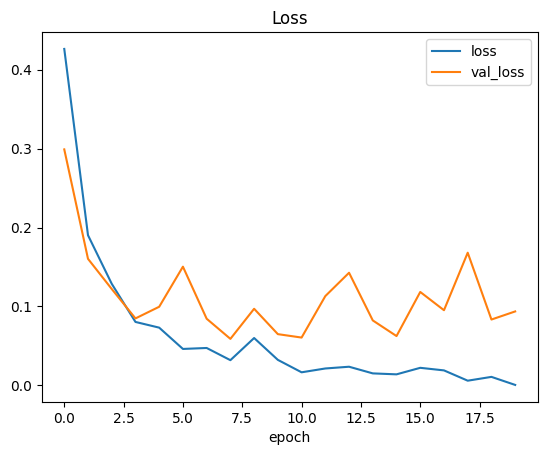

In [36]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

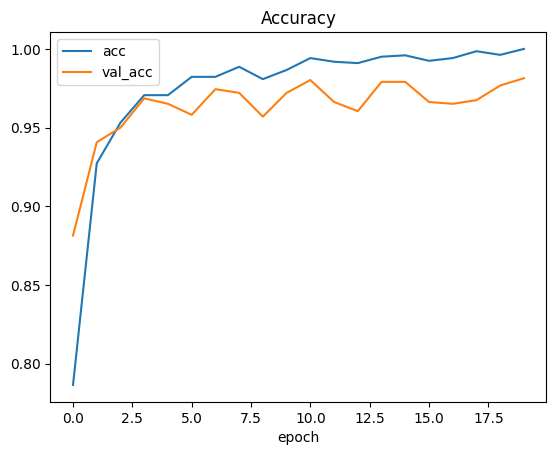

In [37]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')

# Verificamos la clasificación con el set de prueba

In [38]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test score:', score[0])
print('Test accuracy:', score[1])

<class 'list'>
Test score: 0.09366139769554138
Test accuracy: 0.9813953638076782


# Matriz de confusión

In [39]:
# Se calculan las predicciones del modelo para graficar la matriz de confusión
# Se compara contra 0.5 para determinar si es clase 0 ó clase 1
# ya que la salida que da la función Sigmoid es continua entre 0 y 1
y_predict = (model.predict(X_test) > 0.5).astype("int32")

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


<Axes: >

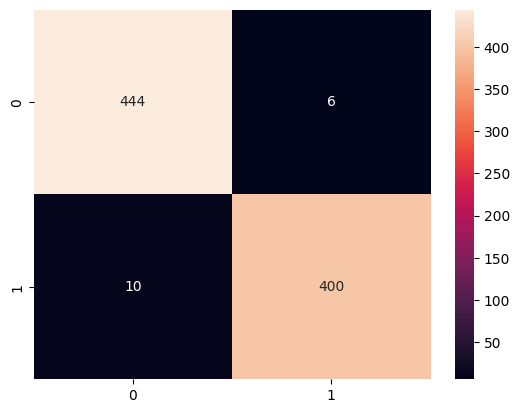

In [40]:
cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot=True, fmt = "d")

In [41]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       450
           1       0.99      0.98      0.98       410

    accuracy                           0.98       860
   macro avg       0.98      0.98      0.98       860
weighted avg       0.98      0.98      0.98       860



#Se somete a prueba con una imagen

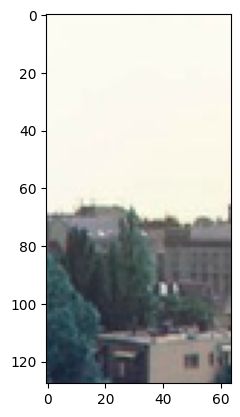

In [42]:
img_color = cv2.imread(background[10])
plt.imshow(img_color, cmap=plt.get_cmap('gray'))

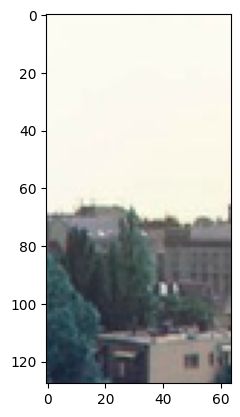

In [43]:
img = cv2.imread(background[10])
plt.imshow(img, cmap=plt.get_cmap('gray'))

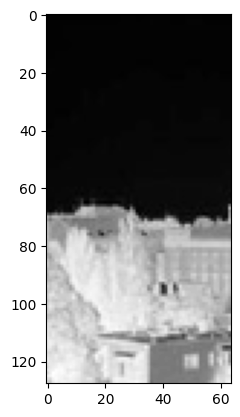

In [44]:
img_arr = np.asarray(img)
img_rs = cv2.resize(img_arr, (64, 128))
img_gray = cv2.cvtColor(img_rs, cv2.COLOR_BGR2GRAY)
img_not = cv2.bitwise_not(img_gray)
plt.imshow(img_not, cmap=plt.get_cmap('gray'))


In [48]:
img_not = img_color/255
img_resh = img_not.reshape(1, 64, 128,3)

prediction = (model.predict(img_resh) > 0.5).astype("int32") # Umbral de 0.5 para clasificación binario
print("predicted digit:", str(prediction[0][0]))# Como <0.5, la clase es 0 (background) , de otra forma sería 1(pedestrian)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted digit: 0


Forma de img_array: (64, 128, 3)
Forma de img_resh: (1, 64, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
valor final de prediccón:  [[0.9999921]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: [1]


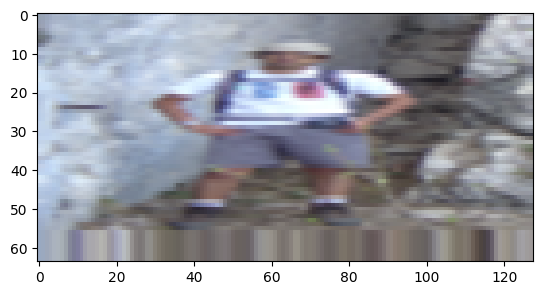

In [53]:
# Cargar y preprocesar la imagen
img_path = pedestrian[40]  # Reemplaza con la ruta de tu imagen
img = Image.open(img_path).resize((128, 64))  # Redimensionar a (128, 64)
plt.imshow(img)
img = img.convert('RGB')  # Asegurarse de que la imagen tenga 3 canales
img_array = np.array(img) / 255.0  # Normalizar valores entre 0 y 1

# Verificar la forma del array
print("Forma de img_array:", img_array.shape)

# Redimensionar la imagen para que tenga una dimensión adicional (batch size)
img_resh = img_array.reshape(1, 64, 128, 3)  # Asegurarse de usar (64, 128, 3) en lugar de aplanar

# Verificar la forma del array redimensionado
print("Forma de img_resh:", img_resh.shape)

# Realizar la predicción
prediction = model.predict(img_resh)
print('valor final de prediccón: ', prediction)
predicted_class = (model.predict(img_resh) > 0.5).astype("int32")

print("Predicted class:", str(predicted_class[0]))

# Guardando y descargando el modelo

In [90]:
model.save('model.h5')

from google.colab import files
files.download('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Video en YouTube

